# **Fetal Health Classification, Self-Learning Tutorial**

Fetal distress and abnormalities during pregnancy can lead to severe complications, including preterm birth, low birth weight, and even neonatal mortality. Early and accurate classification of fetal health – whether normal, at risk, or pathological – allows healthcare professionals to take proactive measures, improving maternal and neonatal outcomes. One of the most reliable diagnostic tools for this purpose is the Cardiotocogram (CTG). However, manual interpretation of CTG data can be subjective and prone to variability, leading to inconsistencies in diagnosis. By applying machine learning to CTG recordings, we can enhance diagnostic accuracy, reduce human error, and facilitate early intervention in high-risk pregnancies.

This project aims to leverage machine learning models to develop a robust predictive system for fetal health classification using CTG data. Through feature selection, model comparison, and performance evaluation, we identify the most effective approach for accurate classification, that can ultimately contribute to better fetal monitoring and care.

# Initial set-up of drive, working directory, and data path

In [ ]:
from google.colab import drive
try:
  drive.mount('/content/drive', force_remount=False)
except:
  pass

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AI_for_Health

/content/drive/MyDrive/AI_for_Health


In [ ]:
# Save your data path here
data_path = "fetal_health.csv"

# Import Packages

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import time
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load Data

In [ ]:
data = pd.read_csv(data_path)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

# Exploratory Data Analysis

### 1. Evaluate if the data is balanced

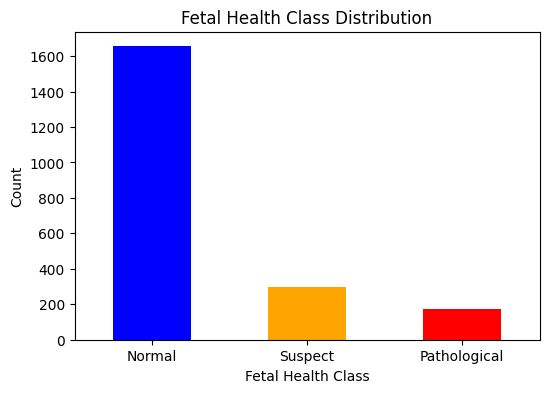

In [ ]:
### Evaluate if the data is balanced
plt.figure(figsize=(6, 4))
data["fetal_health"].value_counts().sort_index().plot(
    kind="bar", color=["blue", "orange", "red"])
plt.title("Fetal Health Class Distribution")
plt.xlabel("Fetal Health Class")
plt.ylabel("Count")
plt.xticks([0, 1, 2],
 ["Normal", "Suspect", "Pathological"], rotation=0)
plt.show()

From this graph, we see that the data is heavily unbalanced. This will influence the modeling techniques that we can choose.

Let's next try to understand the different features in the dataset.

### 2. Plot histograms for each feature in the data, to understand the overall distribution and range of values

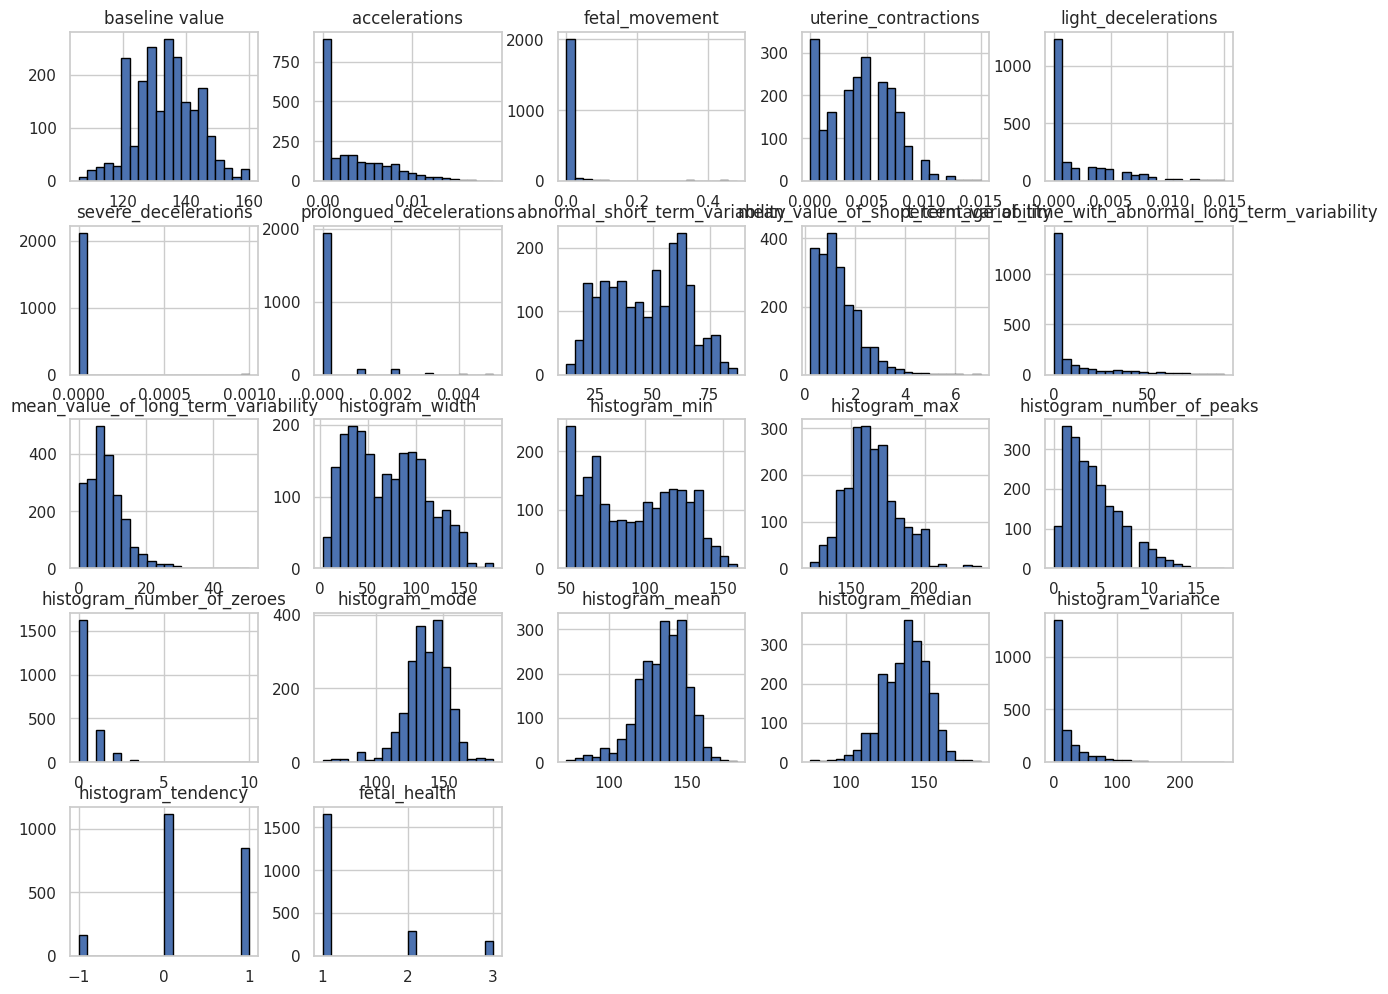

In [ ]:
### Plot histograms for each feature in the data, to understand the overall distribution and range of values

# Set plot style
sns.set(style="whitegrid")

# Plot histograms for all features
data.hist(figsize=(15, 12), bins=20, edgecolor="black")
plt.show()


From the histograms, we notice that severe_decelerations feature has almomst all the records with value ~0 and therefore will not impact model predictions. Similarly, majority of the values for fetal_movement are skewed towards 0, which indicates that this feature might have a lower significance in the prediction model.

We can also learn about other characteristics, for example, in the case of histogram_tendency, this feature has three unique values (-1, 0, and 1) and is not a continuous variable.

In [ ]:
### Looking at the number of unique values in each feature

num_unique_values_per_column = pd.DataFrame(data.nunique()).reset_index()
num_unique_values_per_column.columns = ["feature", "num_unique_values"]
num_unique_values_per_column

,feature,num_unique_values
0,baseline value,48
1,accelerations,20
2,fetal_movement,102
3,uterine_contractions,16
4,light_decelerations,16
5,severe_decelerations,2
6,prolongued_decelerations,6
7,abnormal_short_term_variability,75
8,mean_value_of_short_term_variability,57
9,percentage_of_time_with_abnormal_long_term_var...,87


In [ ]:
### Filtering out those features that have <= 3 unique features, and can be considered as a categorical variable/non-continuous variable

few_unique_values_per_column = num_unique_values_per_column[num_unique_values_per_column["num_unique_values"] <= 3]
for col in few_unique_values_per_column["feature"]:
    print(f"\n{col}:")
    print(data[col].unique())


severe_decelerations:
[0.    0.001]

histogram_tendency:
[ 1.  0. -1.]

fetal_health:
[2. 1. 3.]


### 3. Distribution of features across target classes

By plotting a boxplot of values across the three target classes (1 = Normal, 2 = Suspect, 3 = Pathological), we can compare the mean and variance of each feature dependent on the target value. Large variations in mean and value range suggest that the feature is significant for the prediction model.

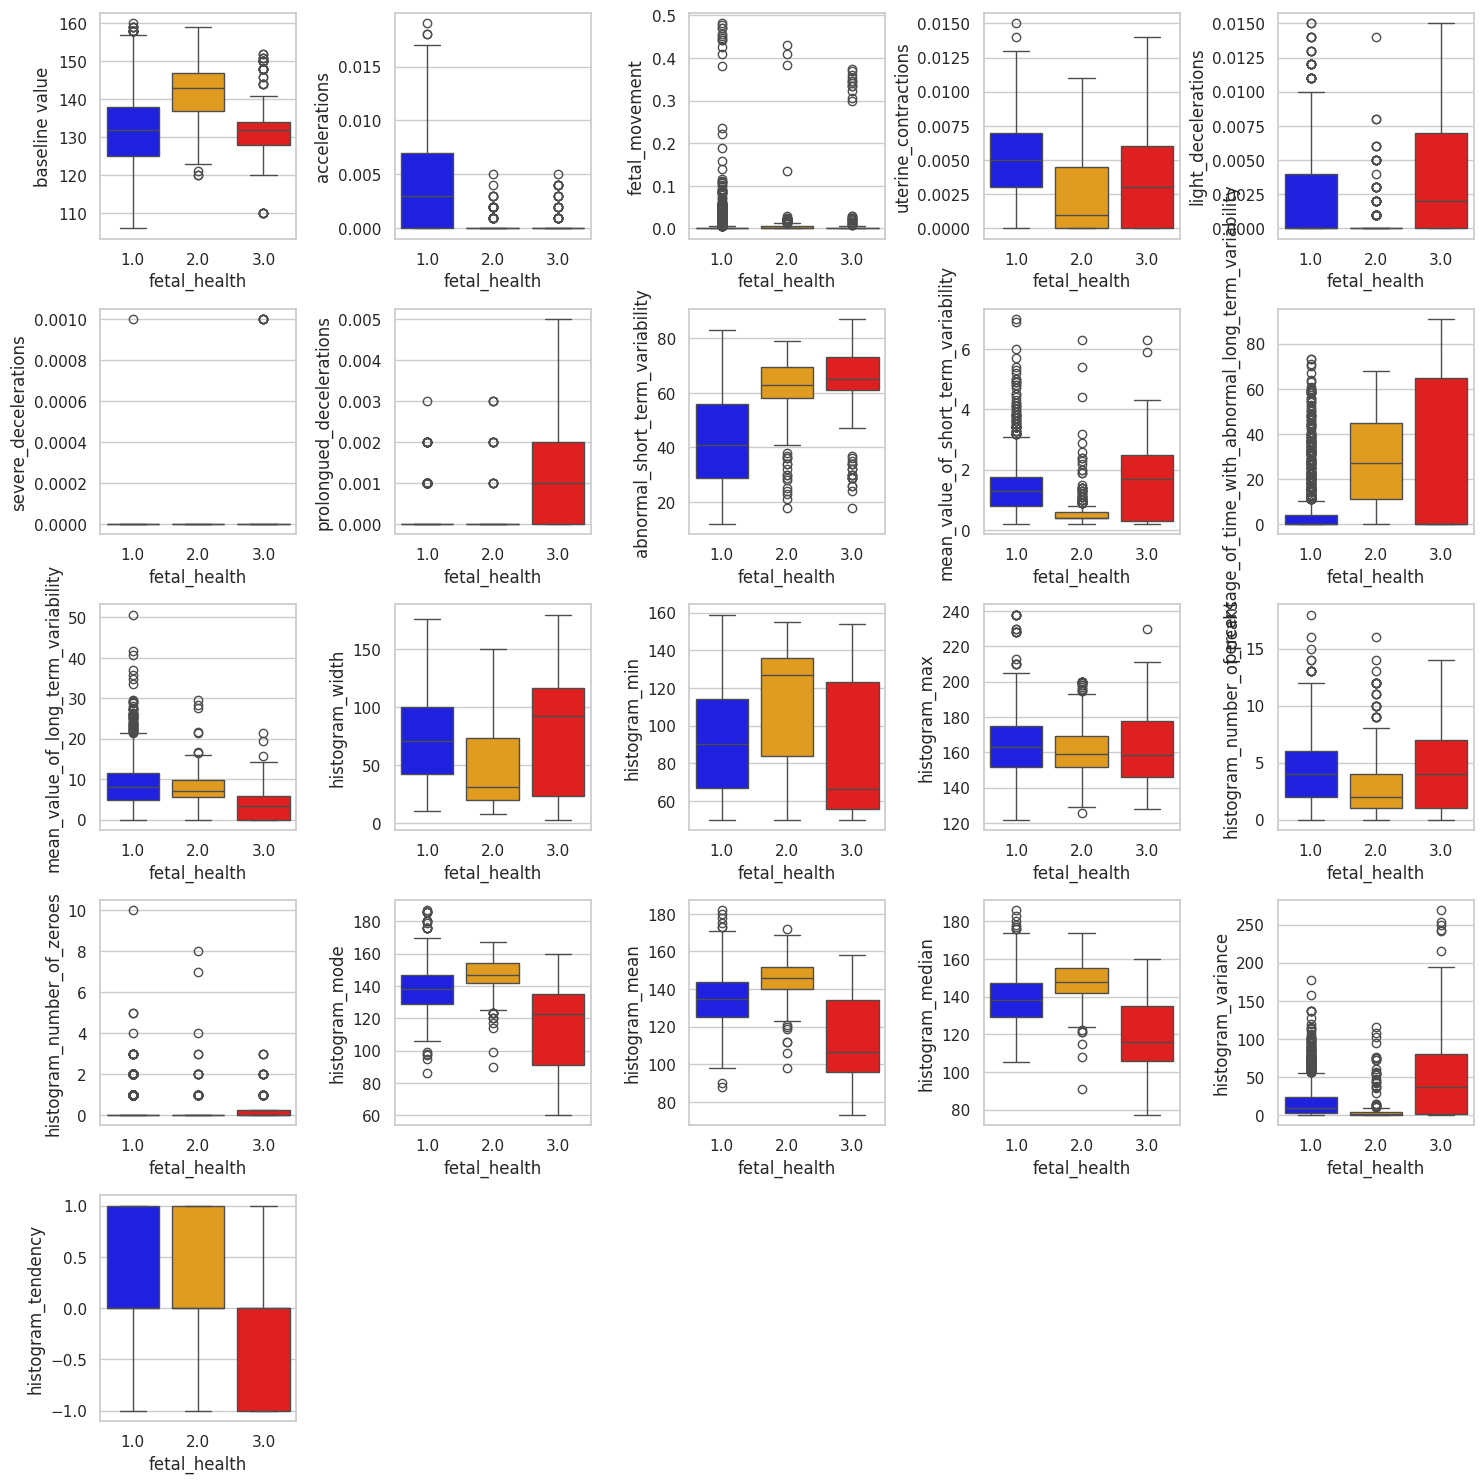

In [ ]:
### Distribution of features across target classes

# Define number of features
num_features = len(data.columns) - 1  # Exclude 'fetal_health'

# Define custom colors for the three classes
custom_palette = {1: "blue", 2: "orange", 3: "red"}

# Determine grid size dynamically
cols = 5
rows = math.ceil(num_features / cols)

plt.figure(figsize=(15, rows * 3))  # Adjust figure height dynamically

for i, col in enumerate(data.columns[:-1], 1):  # Exclude 'fetal_health'
    plt.subplot(rows, cols, i)
    sns.boxplot(data=data, x="fetal_health", y=col, hue="fetal_health", palette=custom_palette, legend=False)
    #plt.title(col)

plt.tight_layout()
plt.show()

### 4. Correlation analysis among independent features

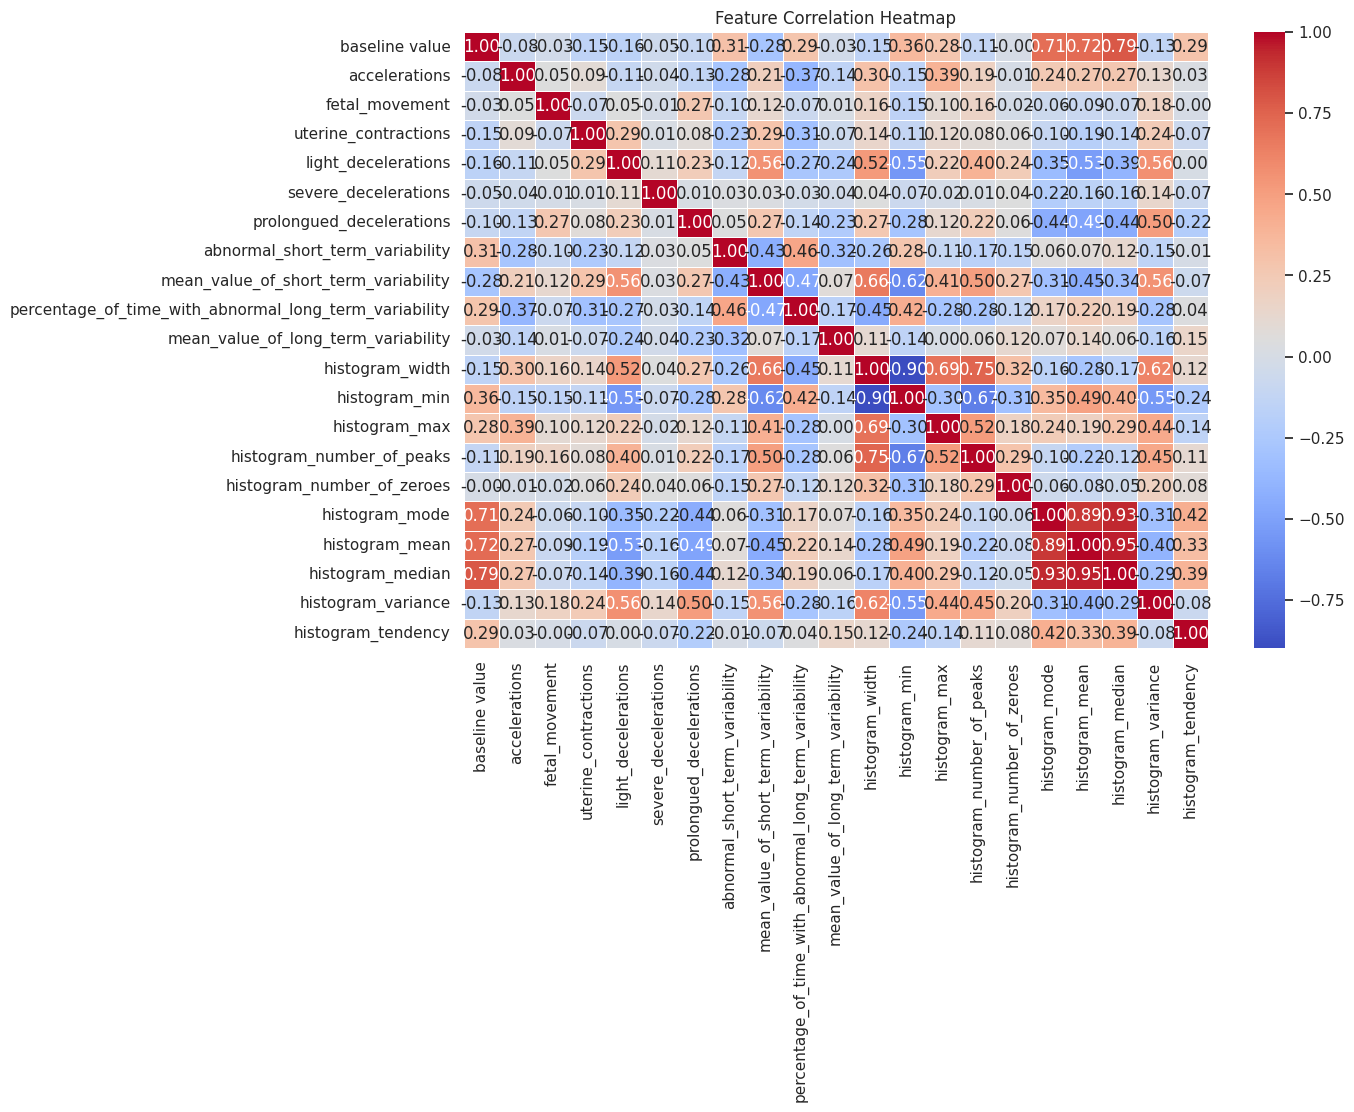

In [ ]:
### Correlation analysis among independent features

plt.figure(figsize=(12, 8))
sns.heatmap(data.drop(columns=["fetal_health"]).corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### 5. ANOVA analysis with target variable

As the target feature is a categorical variable, we cannot reliably establish a dependent relationship/correlation using the correlation analysis. To compute the correlation between a continuous variable and a categorical variable, we employ the ANOVA (Analysis of Variance) technique.

The F value indicates how much of the variation in the target variable can be attributed to that independent feature. A large F value indicates more significant differences between groups and essentially rejecting the null hypothesis.

In [ ]:
### ANOVA analysis with target variable

X = data.drop(columns=["fetal_health"])  # Independent variables
y = data["fetal_health"]  # Target variable

f_values, p_values = f_classif(X, y)
anova_df = pd.DataFrame({"Feature": X.columns, "F-Value": f_values, "P-Value": p_values})
anova_df = anova_df.sort_values(by="F-Value", ascending=False)
anova_df['ANOVA_Rank'] = anova_df['F-Value'].rank(ascending=False).astype(int)
anova_df


,Feature,F-Value,P-Value,ANOVA_Rank
6,prolongued_decelerations,505.853206,2.210238e-180,1
9,percentage_of_time_with_abnormal_long_term_var...,345.156385,1.631148e-130,2
7,abnormal_short_term_variability,343.820419,4.472368e-130,3
17,histogram_mean,297.625497,1.145660e-114,4
16,histogram_mode,275.117696,5.720429e-107,5
18,histogram_median,248.772237,8.606065e-98,6
1,accelerations,196.027523,7.520612e-79,7
19,histogram_variance,150.796849,5.796289e-62,8
0,baseline value,140.621076,4.457098e-58,9
8,mean_value_of_short_term_variability,119.882006,4.695912e-50,10


# Model Building

### Preparing train and test datasets, and computing weights to solve for imbalance

In [ ]:
### Preparing train and test datasets, and computing weights to solve for imbalance

df = data.copy() #Copying the data into a new variable

# Prepare data
X = df.drop(columns=["fetal_health"])
y = df["fetal_health"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict

{1.0: 0.42831947593852354, 2.0: 2.401129943502825, 3.0: 4.0189125295508275}

### Model training and evaluation functions

In [ ]:
### Model training and evaluation functions

def train_and_evaluate_model(model, model_name, x_tr, x_te, y_tr, y_te, sample_weight=None):
  print(f"\nTraining {model_name}...\n")

  if model_name == "XGBoost":
    y_tr_xgb = y_tr - 1 #To convert labels from (1,2,3) to (0,1,2) requirement for XGB
    start_time = time.time()
    if sample_weight is not None:
      model.fit(x_tr, y_tr_xgb, sample_weight=sample_weight)
    else:
      model.fit(x_tr, y_tr_xgb)
    end_time = time.time()
    print(f"Training Time: {end_time - start_time:.2f} seconds")
    train_time = end_time - start_time
    start_time = time.time()
    y_pr = model.predict(x_te) + 1 #Converting back from (0,1,2) to (1,2,3)
    #                               to generate classification report
    end_time = time.time()
    print(f"Inference Time: {end_time - start_time:.2f} seconds")
    infer_time = end_time - start_time
  else:
    start_time = time.time()
    model.fit(x_tr, y_tr)
    end_time = time.time()
    print(f"Training Time: {end_time - start_time:.2f} seconds")
    train_time = end_time - start_time
    start_time = time.time()
    y_pr = model.predict(x_te)
    end_time = time.time()
    print(f"Inference Time: {end_time - start_time:.2f} seconds")
    infer_time = end_time - start_time

  print(f"\nResults for {model_name}:")
  print(classification_report(y_te, y_pr))

  return y_pr, model, train_time, infer_time

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[1,2,3], yticklabels=[1,2,3])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Random Forest model

### 1. Base model definition and evaluation metrics

In [ ]:
# Define model
np.random.seed(42)
random_forest = RandomForestClassifier(n_estimators=500, class_weight=class_weight_dict, random_state=42)

# Train & Evaluate
rf_preds, rf_model, rf_trtime, rf_inftime = train_and_evaluate_model(random_forest, "Random Forest", X_train, X_test, y_train, y_test)


Training Random Forest...

Training Time: 1.86 seconds
Inference Time: 0.06 seconds

Results for Random Forest:
              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       332
         2.0       0.85      0.66      0.74        59
         3.0       0.91      0.91      0.91        35

    accuracy                           0.93       426
   macro avg       0.90      0.85      0.87       426
weighted avg       0.93      0.93      0.93       426



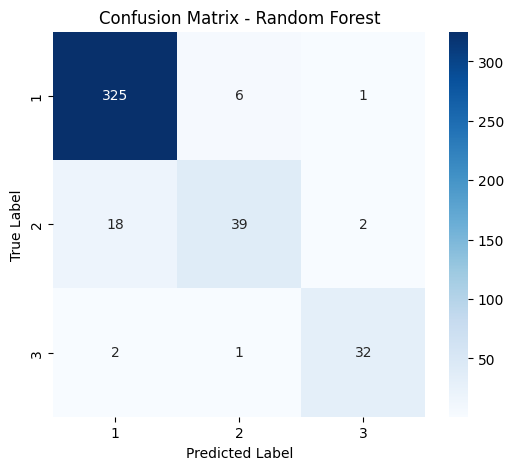

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_test, rf_preds, "Random Forest")

### 2. Improving the Base model with feature selection

In [ ]:
# Feature importance from Random Forest model
feature_importance = pd.DataFrame({"Feature": X_train.columns, "Importance": rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Remove highly correlated features and redundant features (severe_decelerations)
feature_importance = feature_importance[~feature_importance["Feature"].isin(["histogram_mode", "histogram_median"])]
feature_importance = feature_importance[~feature_importance["Feature"].isin(["severe_decelerations"])]

# Merge ANOVA results and calculate a product of the feature importance and F-value as a proxy metric
feature_importance = feature_importance.merge(anova_df, on="Feature", how="left")
feature_importance['product'] = feature_importance['Importance'] * feature_importance['F-Value']
feature_importance = feature_importance.sort_values(by="product", ascending=False)

# Significance ranking
feature_importance['RF_Rank'] = feature_importance['Importance'].rank(ascending=False).astype(int)
feature_importance['ANOVA_Rank'] = feature_importance['F-Value'].rank(ascending=False).astype(int)
feature_importance['product_Rank'] = feature_importance['product'].rank(ascending=False).astype(int)

feature_importance[['Feature','RF_Rank','ANOVA_Rank','product_Rank','Importance','F-Value','product']]

,Feature,RF_Rank,ANOVA_Rank,product_Rank,Importance,F-Value,product
0,abnormal_short_term_variability,1,3,1,0.131835,343.820419,45.327506
1,percentage_of_time_with_abnormal_long_term_var...,2,2,2,0.125068,345.156385,43.168123
5,prolongued_decelerations,6,1,3,0.058520,505.853206,29.602707
2,histogram_mean,3,4,4,0.097881,297.625497,29.131831
3,accelerations,4,5,5,0.073163,196.027523,14.341894
4,mean_value_of_short_term_variability,5,8,6,0.072878,119.882006,8.736739
7,baseline value,8,7,7,0.041722,140.621076,5.867029
8,histogram_variance,9,6,8,0.036979,150.796849,5.576279
6,mean_value_of_long_term_variability,7,11,9,0.058358,70.174093,4.095205
11,histogram_min,12,10,10,0.027696,87.340503,2.418992


In [ ]:
select_features = feature_importance["Feature"][
    feature_importance["product_Rank"] <= 6]
select_features

,Feature
0,abnormal_short_term_variability
1,percentage_of_time_with_abnormal_long_term_var...
5,prolongued_decelerations
2,histogram_mean
3,accelerations
4,mean_value_of_short_term_variability


### 3. Feature-selected model

In [ ]:
# Filter for selected features data
X_train_sel = X_train[select_features]
X_test_sel = X_test[select_features]

# Train & Evaluate
np.random.seed(42)
rf_sel_preds, rf_sel_model, rf_sel_trtime, rf_sel_inftime = train_and_evaluate_model(
    random_forest, "Random Forest", X_train_sel, X_test_sel, y_train, y_test)


Training Random Forest...

Training Time: 1.70 seconds
Inference Time: 0.10 seconds

Results for Random Forest:
              precision    recall  f1-score   support

         1.0       0.95      0.98      0.96       332
         2.0       0.87      0.68      0.76        59
         3.0       0.86      0.91      0.89        35

    accuracy                           0.93       426
   macro avg       0.89      0.86      0.87       426
weighted avg       0.93      0.93      0.93       426



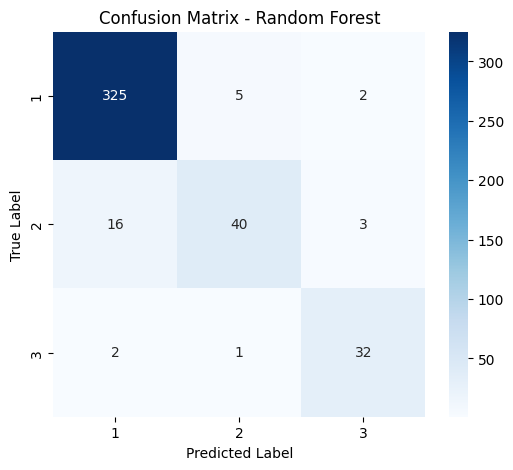

In [ ]:
# Plot confusion matrix for feature selected model
plot_confusion_matrix(y_test, rf_sel_preds, "Random Forest")

# XGBoost model

### 1. Base model definition and evaluation metrics

In [ ]:
# Define model
np.random.seed(42)
xgboost = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, objective="multi:softmax", num_class=3)

# Assign sample weights
sample_weights = y_train.map(class_weight_dict)

# Train & Evaluate
xgb_preds, xgb_model, xgb_trtime, xgb_inftime = train_and_evaluate_model(xgboost, "XGBoost", X_train, X_test, y_train, y_test, sample_weight=sample_weights)


Training XGBoost...

Training Time: 3.68 seconds
Inference Time: 0.02 seconds

Results for XGBoost:
              precision    recall  f1-score   support

         1.0       0.96      0.97      0.97       332
         2.0       0.82      0.78      0.80        59
         3.0       0.89      0.91      0.90        35

    accuracy                           0.94       426
   macro avg       0.89      0.89      0.89       426
weighted avg       0.94      0.94      0.94       426



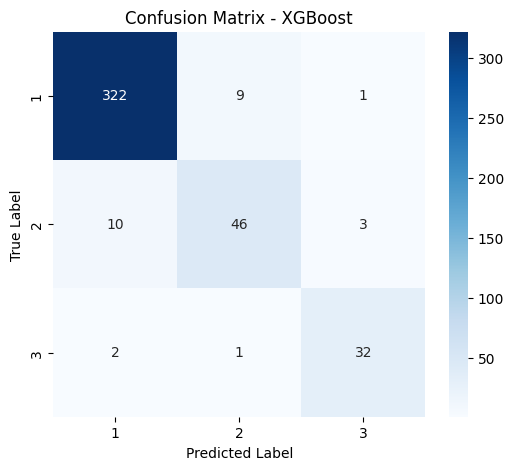

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_test, xgb_preds, "XGBoost")

### 2. Improving the Base model with feature selection

In [ ]:
# Feature importance from XGBoost model
feature_importance = pd.DataFrame({"Feature": X_train.columns, "Importance": xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Remove highly correlated features and redundant features (severe_decelerations)
feature_importance = feature_importance[~feature_importance["Feature"].isin(["histogram_mode", "histogram_median"])]
feature_importance = feature_importance[~feature_importance["Feature"].isin(["severe_decelerations"])]

# Merge ANOVA results and calculate a product of the feature importance and F-value as a proxy metric
feature_importance = feature_importance.merge(anova_df, on="Feature", how="left")
feature_importance['product'] = feature_importance['Importance'] * feature_importance['F-Value']
feature_importance = feature_importance.sort_values(by="product", ascending=False)

# Significance ranking
feature_importance['XGB_Rank'] = feature_importance['Importance'].rank(ascending=False).astype(int)
feature_importance['ANOVA_Rank'] = feature_importance['F-Value'].rank(ascending=False).astype(int)
feature_importance['product_Rank'] = feature_importance['product'].rank(ascending=False).astype(int)

feature_importance[['Feature','XGB_Rank','ANOVA_Rank','product_Rank','Importance','F-Value','product']]

,Feature,XGB_Rank,ANOVA_Rank,product_Rank,Importance,F-Value,product
1,percentage_of_time_with_abnormal_long_term_var...,2,2,1,0.164035,345.156385,56.617555
3,prolongued_decelerations,4,1,2,0.099351,505.853206,50.256839
0,histogram_mean,1,4,3,0.167666,297.625497,49.901589
2,abnormal_short_term_variability,3,3,4,0.121619,343.820419,41.815119
4,accelerations,5,5,5,0.092543,196.027523,18.140978
5,baseline value,6,7,6,0.035400,140.621076,4.977924
6,mean_value_of_short_term_variability,7,8,7,0.024420,119.882006,2.927472
7,uterine_contractions,8,9,8,0.022228,93.715743,2.083068
14,histogram_variance,15,6,9,0.010477,150.796849,1.579897
13,histogram_min,14,10,10,0.011812,87.340503,1.031656


In [ ]:
select_features = feature_importance["Feature"][
    feature_importance["product_Rank"] <= 10]
select_features

,Feature
1,percentage_of_time_with_abnormal_long_term_var...
3,prolongued_decelerations
0,histogram_mean
2,abnormal_short_term_variability
4,accelerations
5,baseline value
6,mean_value_of_short_term_variability
7,uterine_contractions
14,histogram_variance
13,histogram_min


### 3. Feature-selected model

In [ ]:
# Filter for selected features data
X_train_sel = X_train[select_features]
X_test_sel = X_test[select_features]

# Train & Evaluate
np.random.seed(42)
xgb_sel_preds, xgb_sel_model, xgb_sel_trtime, xgb_sel_inftime = train_and_evaluate_model(
    xgboost, "XGBoost", X_train_sel, X_test_sel, y_train, y_test, sample_weight=sample_weights)


Training XGBoost...

Training Time: 0.89 seconds
Inference Time: 0.02 seconds

Results for XGBoost:
              precision    recall  f1-score   support

         1.0       0.97      0.97      0.97       332
         2.0       0.82      0.80      0.81        59
         3.0       0.86      0.91      0.89        35

    accuracy                           0.94       426
   macro avg       0.89      0.89      0.89       426
weighted avg       0.94      0.94      0.94       426



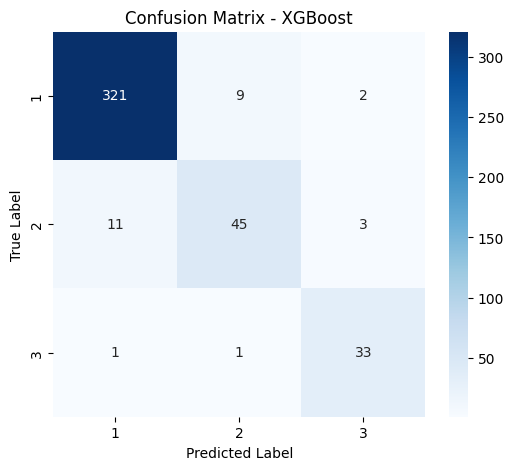

In [ ]:
# Plot confusion matrix for feature selected model
plot_confusion_matrix(y_test, xgb_sel_preds, "XGBoost")

# CatBoost model

### 1. Base model definition and evaluation metrics

In [ ]:
# Define model
np.random.seed(42)
catboost = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6,
                              loss_function='MultiClass', class_weights=list(class_weight_dict.values()),
                              eval_metric='TotalF1', verbose=50)

# Train & Evaluate
cb_preds, cb_model, cb_trtime, cb_inftime = train_and_evaluate_model(catboost, "CatBoost", X_train, X_test, y_train, y_test)


Training CatBoost...

0:	learn: 0.7907693	total: 82.8ms	remaining: 41.3s
50:	learn: 0.9266037	total: 478ms	remaining: 4.21s
100:	learn: 0.9450185	total: 1.05s	remaining: 4.15s
150:	learn: 0.9530592	total: 1.62s	remaining: 3.74s
200:	learn: 0.9654515	total: 2.05s	remaining: 3.05s
250:	learn: 0.9762825	total: 2.46s	remaining: 2.44s
300:	learn: 0.9822553	total: 3.05s	remaining: 2.02s
350:	learn: 0.9886288	total: 4.08s	remaining: 1.73s
400:	learn: 0.9911639	total: 5.07s	remaining: 1.25s
450:	learn: 0.9929375	total: 5.8s	remaining: 630ms
499:	learn: 0.9944529	total: 6.54s	remaining: 0us
Training Time: 9.10 seconds
Inference Time: 0.01 seconds

Results for CatBoost:
              precision    recall  f1-score   support

         1.0       0.97      0.96      0.97       332
         2.0       0.77      0.83      0.80        59
         3.0       0.91      0.91      0.91        35

    accuracy                           0.94       426
   macro avg       0.88      0.90      0.89       426
weig

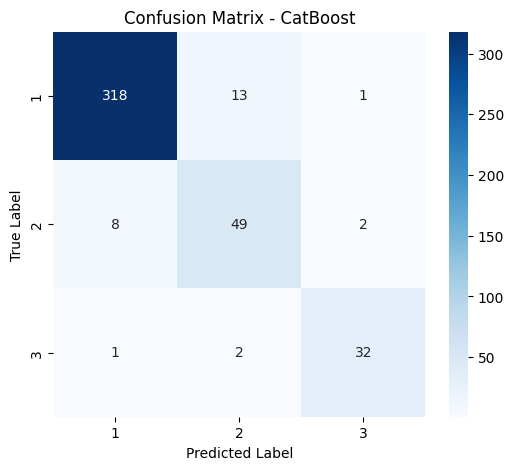

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_test, cb_preds, "CatBoost")

### 2. Improving the Base model with feature selection

In [ ]:
# Feature importance from CatBoost model
feature_importance = pd.DataFrame({"Feature": X_train.columns, "Importance": cb_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Remove highly correlated features and redundant features (severe_decelerations)
feature_importance = feature_importance[~feature_importance["Feature"].isin(["histogram_mode", "histogram_median"])]
feature_importance = feature_importance[~feature_importance["Feature"].isin(["severe_decelerations"])]

# Merge ANOVA results and calculate a product of the feature importance and F-value as a proxy metric
feature_importance = feature_importance.merge(anova_df, on="Feature", how="left")
feature_importance['product'] = feature_importance['Importance'] * feature_importance['F-Value']
feature_importance = feature_importance.sort_values(by="product", ascending=False)

# Significance ranking
feature_importance['CB_Rank'] = feature_importance['Importance'].rank(ascending=False).astype(int)
feature_importance['ANOVA_Rank'] = feature_importance['F-Value'].rank(ascending=False).astype(int)
feature_importance['product_Rank'] = feature_importance['product'].rank(ascending=False).astype(int)

feature_importance[['Feature','CB_Rank','ANOVA_Rank','product_Rank','Importance','F-Value','product']]

,Feature,CB_Rank,ANOVA_Rank,product_Rank,Importance,F-Value,product
0,percentage_of_time_with_abnormal_long_term_var...,1,2,1,17.318367,345.156385,5977.545078
1,abnormal_short_term_variability,2,3,2,16.547560,343.820419,5689.388886
2,prolongued_decelerations,3,1,3,8.383132,505.853206,4240.634294
5,histogram_mean,6,4,4,6.426117,297.625497,1912.576140
4,accelerations,5,5,5,7.062000,196.027523,1384.346411
3,mean_value_of_short_term_variability,4,8,6,7.502780,119.882006,899.448273
8,histogram_variance,9,6,7,3.388844,150.796849,511.026927
6,uterine_contractions,7,9,8,5.294462,93.715743,496.174420
9,baseline value,10,7,9,3.085732,140.621076,433.918981
7,mean_value_of_long_term_variability,8,11,10,4.352867,70.174093,305.458513


In [ ]:
select_features = feature_importance["Feature"][
    feature_importance["product_Rank"] <= 12]
select_features

,Feature
0,percentage_of_time_with_abnormal_long_term_var...
1,abnormal_short_term_variability
2,prolongued_decelerations
5,histogram_mean
4,accelerations
3,mean_value_of_short_term_variability
8,histogram_variance
6,uterine_contractions
9,baseline value
7,mean_value_of_long_term_variability


### 3. Feature-selected model

In [ ]:
# Filter for selected features data (product_rank <= 12)
X_train_sel = X_train[select_features]
X_test_sel = X_test[select_features]

# Train & Evaluate
np.random.seed(42)
cb_sel_preds, cb_sel_model, cb_sel_trtime, cb_sel_inftime = train_and_evaluate_model(
    catboost, "CatBoost", X_train_sel, X_test_sel, y_train, y_test)


Training CatBoost...

0:	learn: 0.8357939	total: 7.69ms	remaining: 3.84s
50:	learn: 0.9233727	total: 569ms	remaining: 5.01s
100:	learn: 0.9411651	total: 1.07s	remaining: 4.23s
150:	learn: 0.9470588	total: 1.57s	remaining: 3.63s
200:	learn: 0.9555664	total: 1.87s	remaining: 2.78s
250:	learn: 0.9716540	total: 2.14s	remaining: 2.12s
300:	learn: 0.9830217	total: 2.62s	remaining: 1.73s
350:	learn: 0.9883758	total: 3.12s	remaining: 1.32s
400:	learn: 0.9911639	total: 3.38s	remaining: 835ms
450:	learn: 0.9921744	total: 3.62s	remaining: 394ms
499:	learn: 0.9941990	total: 3.96s	remaining: 0us
Training Time: 4.64 seconds
Inference Time: 0.00 seconds

Results for CatBoost:
              precision    recall  f1-score   support

         1.0       0.98      0.94      0.96       332
         2.0       0.71      0.86      0.78        59
         3.0       0.89      0.91      0.90        35

    accuracy                           0.93       426
   macro avg       0.86      0.91      0.88       426
wei

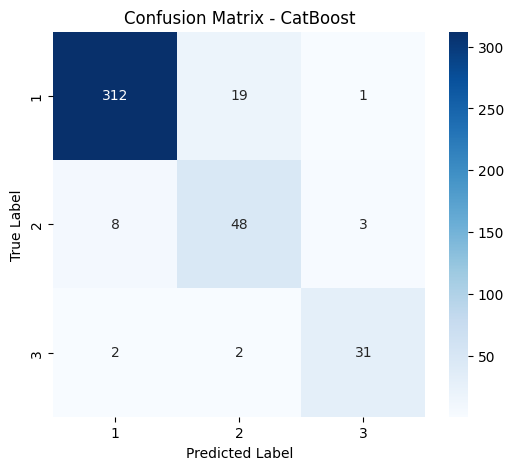

In [ ]:
# Plot confusion matrix for feature selected model
plot_confusion_matrix(y_test, cb_sel_preds, "CatBoost")

# Comparison of different model results

### 1. Plot feature importance of all models

In [ ]:
# Define model
np.random.seed(42)
random_forest = RandomForestClassifier(n_estimators=500, class_weight=class_weight_dict, random_state=42)
xgboost = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, objective="multi:softmax", num_class=3)
catboost = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, loss_function='MultiClass', class_weights=list(class_weight_dict.values()), eval_metric='TotalF1', verbose=50)

# Train & Evaluate
rf_preds, rf_model, rf_trtime, rf_inftime = train_and_evaluate_model(random_forest, "Random Forest", X_train, X_test, y_train, y_test)
xgb_preds, xgb_model, xgb_trtime, xgb_inftime = train_and_evaluate_model(xgboost, "XGBoost", X_train, X_test, y_train, y_test, sample_weight=sample_weights)
cb_preds, cb_model, cb_trtime, cb_inftime = train_and_evaluate_model(catboost, "CatBoost", X_train, X_test, y_train, y_test)


Training Random Forest...

Training Time: 2.61 seconds
Inference Time: 0.08 seconds

Results for Random Forest:
              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       332
         2.0       0.85      0.66      0.74        59
         3.0       0.91      0.91      0.91        35

    accuracy                           0.93       426
   macro avg       0.90      0.85      0.87       426
weighted avg       0.93      0.93      0.93       426


Training XGBoost...

Training Time: 2.46 seconds
Inference Time: 0.02 seconds

Results for XGBoost:
              precision    recall  f1-score   support

         1.0       0.96      0.97      0.97       332
         2.0       0.82      0.78      0.80        59
         3.0       0.89      0.91      0.90        35

    accuracy                           0.94       426
   macro avg       0.89      0.89      0.89       426
weighted avg       0.94      0.94      0.94       426


Training CatBoost...

0

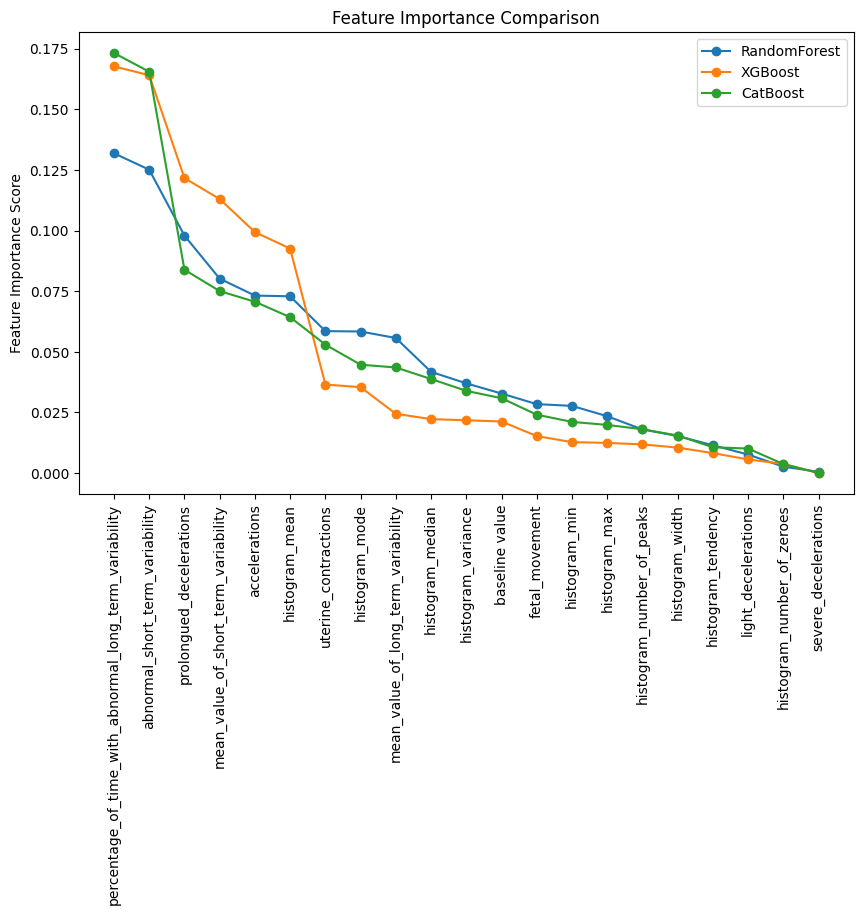

In [ ]:
def plot_feature_importance_line(models, feature_names):
    plt.figure(figsize=(10, 6))

    for name, model in models.items():
        importance = model.feature_importances_
        if name == "CatBoost":
            importance = importance / 100
        sorted_indices = np.argsort(importance)[::-1]
        plt.plot(np.arange(len(feature_names)), importance[sorted_indices], marker='o', label=name)

    plt.xticks(np.arange(len(feature_names)), np.array(feature_names)[sorted_indices], rotation=90)
    plt.ylabel("Feature Importance Score")
    plt.title("Feature Importance Comparison")
    plt.legend()
    plt.show()

# Example Usage:
models = {
    "RandomForest": rf_model,
    "XGBoost": xgb_model,
    "CatBoost": cb_model
}
plot_feature_importance_line(models, X_train.columns)


### 2. Compare run time of models

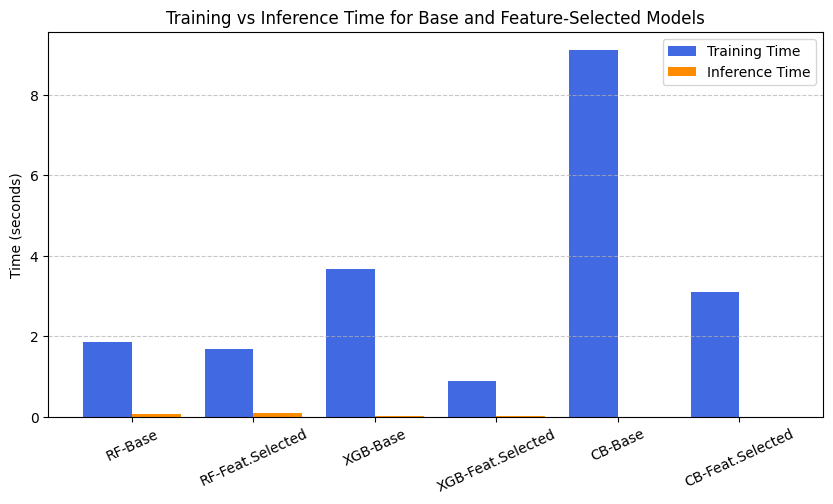

In [ ]:
# Updated time lists
train_times = [rf_trtime, rf_sel_trtime, xgb_trtime, xgb_sel_trtime, cb_trtime, cb_sel_trtime]
infer_times = [rf_inftime, rf_sel_inftime, xgb_inftime, xgb_sel_inftime, cb_inftime, cb_sel_inftime]

# Updated x-axis labels
x_labels = ["RF-Base", "RF-Feat.Selected", "XGB-Base", "XGB-Feat.Selected", "CB-Base", "CB-Feat.Selected"]
x = np.arange(len(x_labels))

# Adjust figure size for better readability
plt.figure(figsize=(10, 5))

# Plot bars with better spacing
plt.bar(x - 0.2, train_times, width=0.4, label="Training Time", color="royalblue")
plt.bar(x + 0.2, infer_times, width=0.4, label="Inference Time", color="darkorange")

# Labeling
plt.xticks(x, x_labels, rotation=25)
plt.ylabel("Time (seconds)")
plt.title("Training vs Inference Time for Base and Feature-Selected Models")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

# Summary

- In this tutorial, we developed a classification system to predict the fetal health from CTG data.

- Exploratory analysis of the data helped us identify class imbalances in the data and extract the highly correlated features that would be significant for predictive modeling.

- Three classification systems were designed: Random Forest, XGBoost, and CatBoost. These models were then improved with feature selection.

- Among all the models, CatBoost yielded the highest recall rates for classes 2 and 3 (classes for not normal fetal health). As we understand recall rate to be the more crucial metric in the scenario of healthcare classification, we can conclude that CatBoost model has the best performance out of all three modeling techniques.

- These results could be improved with data enhancements in the form of feature engineering and outlier handling, implementation of deep-learning models in place of machine-learning techniques, and cross-validation of these results with hospital and medical experts.